# 使用两层 `ReLU` 网络拟合函数
理论和实验证明，一个两层的 `ReLU` 网络能够逼近任意函数。以下是实验证明过程，步骤如下：
- 自定义函数，根据函数表达式生成训练数据和测试数据
- 构建模型，一个两层的 `ReLU` 网络
- 使用训练数据训练模型
- 使用测试数据评估拟合效果



## [自定义函数]
函数：$y=3x^3+4x^2+5x+6$

## [数据采集]
首先生成所需数据，由函数定义式可知， $x$ 有三个特征，并且是非线性相关

In [53]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

In [54]:
true_w2 = torch.tensor([3,4,5,],dtype=torch.float32)
true_b2 = 6

In [55]:
def synthetic_data(num_examples):
    '''生成数据'''
    x = torch.normal(0,1,(num_examples,3))
    y = 3 * torch.pow(x[:,0],3) + 4 * torch.pow(x[:,1],2) + 5 * x[:,2] + 6
    return x,y.reshape(-1,1)
        

In [56]:
def scale_data(x,y):
    '''数据标准化'''
    x_mean = torch.mean(x)
    x_std = torch.std(x)
    y_mean = torch.mean(y)
    y_std = torch.std(y)
    
    x_scale = (x - x_mean) / x_std
    y_scale = (y - y_mean) / y_std
    
    return x_scale,y_scale

In [57]:
x,y = synthetic_data(1000)
x,y = scale_data(x,y)
x.shape,y.shape

(torch.Size([1000, 3]), torch.Size([1000, 1]))

划分训练集和测试集

In [58]:
portion = 700
x_train,y_train = x[:portion,:],y[:portion,:]
x_test,y_test = x[portion:,:],y[portion:,:]
print(f"training set size: {x_train.shape}")
print(f"test set size: {x_test.shape}")

training set size: torch.Size([700, 3])
test set size: torch.Size([300, 3])


使用散点图可视化各个维度的特征与标签的关系

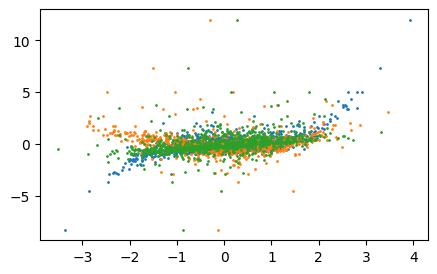

In [59]:
plt.figure(figsize=(5,3))
plt.scatter(x[:,0].detach().numpy(),y.detach().numpy(),1)
plt.scatter(x[:,1].detach().numpy(),y.detach().numpy(),1)
plt.scatter(x[:,2].detach().numpy(),y.detach().numpy(),1)

虽然点与点之间有重叠，但是可以看到前两个特征与目标 $y$ 是非线性关系，最后一维特征与 $y$ 大致呈线性关系。这也与定义的函数相符合。

## 构建模型

In [60]:
class ReLU_2(nn.Module):
    def __init__(self,num_inputs,num_hidden1,num_hidden2,num_outputs):
        super(ReLU_2,self).__init__()
        self.W1 = nn.Parameter(torch.normal(0,0.1,size=(num_inputs,num_hidden1),requires_grad=True))
        self.b1 = nn.Parameter(torch.zeros((1,num_hidden1),requires_grad=True))
        
        self.W2 = nn.Parameter(torch.normal(0,0.1,size=(num_hidden1,num_hidden2),requires_grad=True))
        self.b2 = nn.Parameter(torch.zeros((1,num_hidden2),requires_grad=True))
        
        self.W3 = nn.Parameter(torch.normal(0,0.1,size=(num_hidden2,num_outputs),requires_grad=True))
        self.b3 = nn.Parameter(torch.zeros((1,num_outputs),requires_grad=True))
    
    def forward(self,x):
        h1 = F.relu(torch.matmul(x,self.W1)+self.b1)
        h2 = F.relu(torch.matmul(h1,self.W2)+self.b2)
        outputs = torch.matmul(h2,self.W3)+self.b3
        return outputs
    


In [61]:
num_epochs,lr = 200,0.1
relu_2 = ReLU_2(num_inputs=3,num_hidden1=4,num_hidden2=6,num_outputs=1)
optimizer = torch.optim.Adam(relu_2.parameters(),lr=lr)

## [训练模型]


In [62]:
def MSE_loss(y_hat,y):
    return torch.mean((y_hat - y.reshape(y_hat.shape)) ** 2)

In [63]:
losses = []
def train(net,x,y,num_epochs,lr,optimizer):
    for epoch in range(num_epochs):
        y_hat = net(x)
        loss = MSE_loss(y_hat,y)
        losses.append(loss.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch+1}\tloss: {loss}")   
    return y_hat

In [64]:
y_hat = train(relu_2,x_train,y_train,num_epochs,lr,optimizer)

epoch: 1	loss: 0.8708505630493164
epoch: 2	loss: 0.862799346446991
epoch: 3	loss: 0.822033166885376
epoch: 4	loss: 0.7487866282463074
epoch: 5	loss: 0.6568893194198608
epoch: 6	loss: 0.5800580978393555
epoch: 7	loss: 0.5139411091804504
epoch: 8	loss: 0.5113966464996338
epoch: 9	loss: 0.5230138897895813
epoch: 10	loss: 0.5129273533821106
epoch: 11	loss: 0.47555986046791077
epoch: 12	loss: 0.435470849275589
epoch: 13	loss: 0.41098228096961975
epoch: 14	loss: 0.39447152614593506
epoch: 15	loss: 0.38474220037460327
epoch: 16	loss: 0.3712042272090912
epoch: 17	loss: 0.35353395342826843
epoch: 18	loss: 0.3312888741493225
epoch: 19	loss: 0.30406448245048523
epoch: 20	loss: 0.27901023626327515
epoch: 21	loss: 0.25743770599365234
epoch: 22	loss: 0.24557143449783325
epoch: 23	loss: 0.24266542494297028
epoch: 24	loss: 0.24132414162158966
epoch: 25	loss: 0.2360493242740631
epoch: 26	loss: 0.22872048616409302
epoch: 27	loss: 0.2225431650876999
epoch: 28	loss: 0.22020666301250458
epoch: 29	loss: 0.2

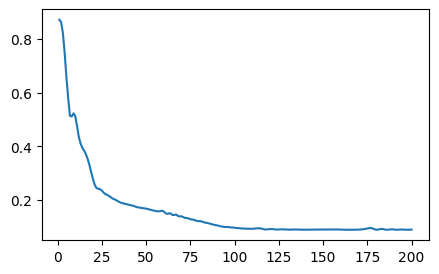

In [65]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1),losses)

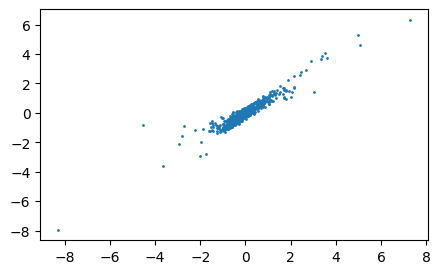

In [66]:
plt.figure(figsize=(5,3))
plt.scatter(y_train.detach().numpy(),y_hat.detach().numpy(),1)
#y_train.shape,y_hat.shape

可以看到图中 $y_{train}-\hat{y}$ 是一条接近于 $y=x$ 的曲线，说明训练集上拟合效果较好

## [评估]

In [67]:
def test(net,x,y):
    y_hat = net(x)
    loss = MSE_loss(y_hat,y)
    print(f"loss on test set: {loss}")
    return y_hat

y_hat = test(relu_2,x_test,y_test)

loss on test set: 0.1629670113325119


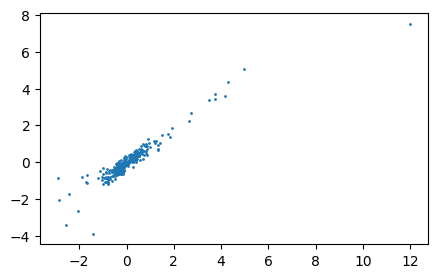

In [68]:
plt.figure(figsize=(5,3))
plt.scatter(y_test.detach().numpy(),y_hat.detach().numpy(),1)

从图中可以看出，$y_{test}-\hat{y}$ 是一条接近 $y=x$ 的曲线，说明模型在测试集上的拟合效果同样良好